# Inferring Photometric Redshifts from Multichannel Images
## Balázs Menkó (O67UT7)
### Supervisor: Pál, Balázs 

---
# Task


Spectroscopic observations of distant astronomical targets are increasingly difficult and expensive to obtain. Therefore, it is crucial to develop methods for inferring the physical parameters of objects from photometric data, which is the only type of observation available at high redshifts. The Sloan Digital Sky Survey (SDSS) data set is a valuable resource for this task, as it contains both photometric and spectroscopic data for a very large number of galaxies.

Analyze the photometric and spectroscopic data of galaxies together! Download coordinates, redshifts and appropriate object identifiers from the SDSS SkyServer! Create square-shaped images from the SDSS sky survey observations that contain single galaxies in the center! Build a simple convolutional neural network that is able to infer redshifts from the cut-out images of galaxies!

How accurate is your model?

Hints
- SDSS data are publicly available and can be accessed through the [SDSS SkyServer](https://skyserver.sdss.org/dr18/). There, they are stored in a relational database, which can be easily queried using the Structured Query Language (SQL). It also offers a large number of SQL tutorials that teach you the basics and even some of the advanced steps on how to interact with data there.
- For convenience, the SkyServer ecosystem provides the [CasJobs](https://skyserver.sdss.org/CasJobs/) interface, which allows for the direct execution of SQL queries on the data servers and the download of the results in various formats.
- A modern alternative to CasJobs is called [Betelgeuse](https://www.sciserver.org/), hosted on SciServer, a general-purpose data science platform and the direct continuation of the SDSS SkyServer project.
- Use the Python tools of SciServer found in the [official GitHub repo](https://github.com/sciserver/SciScript-Python) to download the images. You can e.g. download the `SciServer` folder found under the `py3` directory and place it into your working directory, when you import the SciServer module. You’ll need to use the `SciServer.SkyServer.getJpegImgCutout()` function to get the image cutouts of galaxies.
- Alternatively, SkyServer provides a cloud-based Jupyter notebook environment called [SciServer Compute](https://apps.sciserver.org/compute/), where you can run your Python code directly on the data servers. This way, you can avoid downloading the data to your local machine, which can be very time-consuming, inefficient, and many times simply impossible due to the sheer size of the data. Here you can use the SciServer/SkyServer library out of the box.

---

# Explore SDSS Database

install `astroquery` packages
```python
%%bash
pip install astroquery
```

In [1]:
from utils import *

# SDSS [Schema Browser](https://skyserver.sdss.org/dr17/MoreTools/browser?) 

## SpecObj View

## [astroquery.sdss.SDSS](https://astroquery.readthedocs.io/en/latest/sdss/sdss.html) DR17

In [2]:
SDSS.query_sql("""
    SELECT Count(*) AS number_of_records_in_SpecObj_table
    FROM SpecObj 
""").to_pandas()

,number_of_records_in_SpecObj_table
0,5112724


In [3]:
number_of_selected_elemenents = SDSS.query_sql("""
    SELECT Count(*) AS number_of_selected_elemenents
    FROM SpecObj
    WHERE class='Galaxy' 
      AND specobjid < 9223372036854775807 -- Only in BIGINT intervall
      AND zOffset = 0 
      AND zWarning = 0
      AND zErr > 0 
      AND velDispErr > 0
      AND z > zErr*10000
      AND velDisp > velDispErr*10 
""").to_pandas().values[0,0]
print(f'Number of selected elemenents: {number_of_selected_elemenents}')

Number of selected elemenents: 19584


In [4]:
N=3
top_N = SDSS.query_sql(f"""
    SELECT TOP {N} specobjid, ra, dec, z, zErr, velDisp, velDispErr
    FROM SpecObj
    WHERE class='Galaxy' 
      AND specobjid < 9223372036854775807 -- Only in BIGINT intervall
      AND zOffset=0 
      AND zWarning=0
      AND zErr>0 
      AND z>zErr*10000
      AND velDispErr > 0
      AND velDisp > velDispErr*10   
""").to_pandas()
top_N

,specobjid,ra,dec,z,zErr,velDisp,velDispErr
0,299503421340280832,146.51283,-0.845765,0.064902,0.000004,124.2391,7.597929
1,299546852049577984,145.59655,-1.205323,0.147311,0.000007,669.9573,37.833410
2,299616671037941760,145.99917,0.352445,0.143653,0.000013,161.6622,13.258850


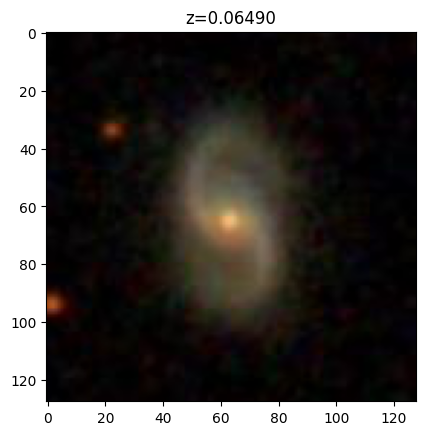

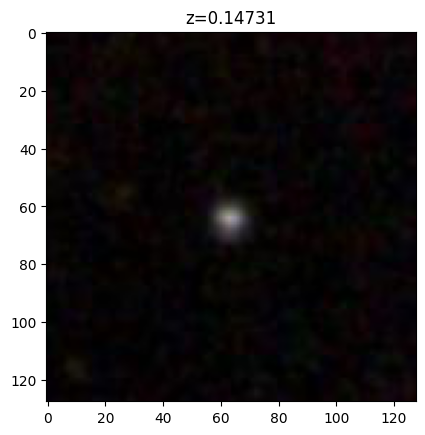

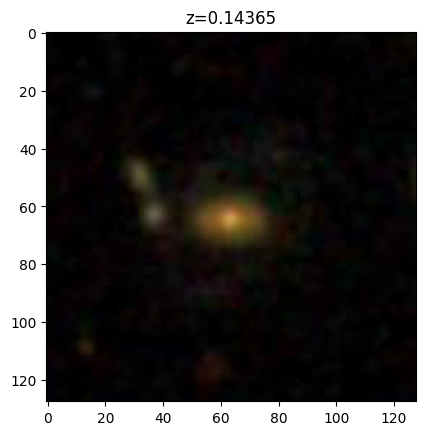

In [5]:
for idx in range(3 if N>=3 else N):
    plt.imshow(reshape_images(get_sdss_image(top_N.ra[idx], top_N.dec[idx])))
    plt.title(f"z={top_N.z[idx]:.5f}", fontsize=FS)
    plt.show()

Save specObjIDs to a `.csv` file
```python
#number_of_selected_elemenents = max(number_of_selected_elemenents, 20000)

data = SDSS.query_sql(f"""
    SELECT TOP  {number_of_selected_elemenents} specobjid
    FROM SpecObj
    WHERE class='Galaxy' 
      AND specobjid < 9223372036854775807 -- Only in BIGINT intervall
      AND zOffset=0 
      AND zWarning=0
      AND zErr>0 
      AND z>zErr*10000
      AND velDispErr > 0
      AND velDisp > velDispErr*10  
""").to_pandas().to_csv('specObjIDs.csv', header=False, index=False)

```